In [1]:
%time
%matplotlib widget
import sys
sys.path.append('/scratch/ss4338/2020/')
import xarray as xr
import numpy as np
import pandas as pd
import dask
import xroms
import matplotlib.pyplot as plt

from track import track
from Interpolation import interpolation

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


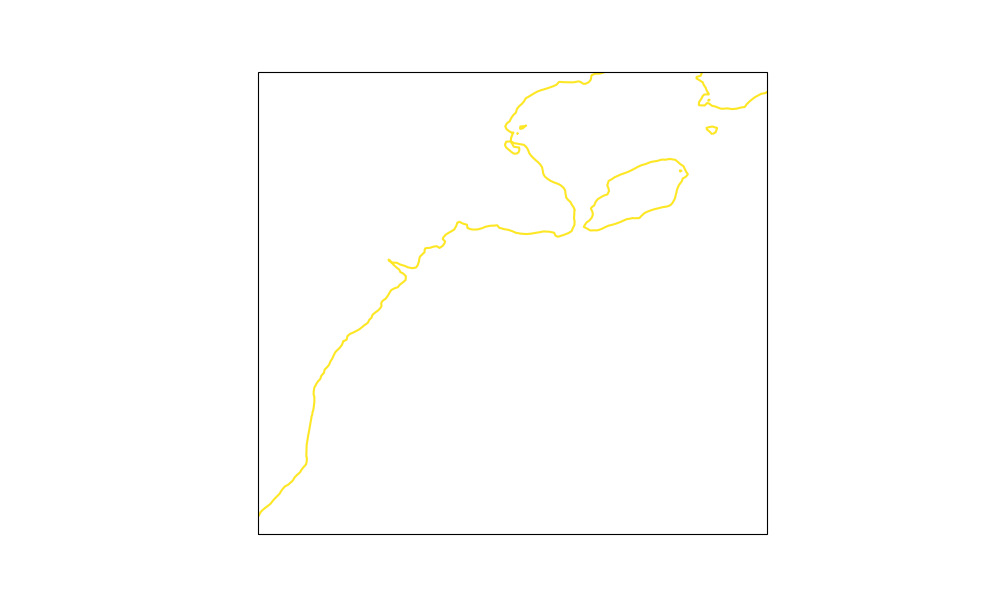

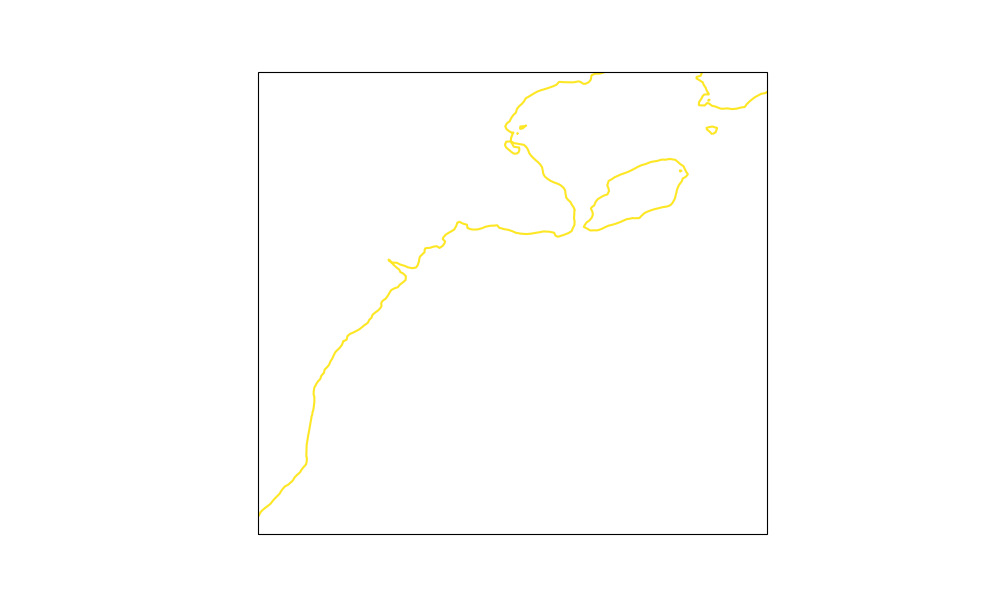

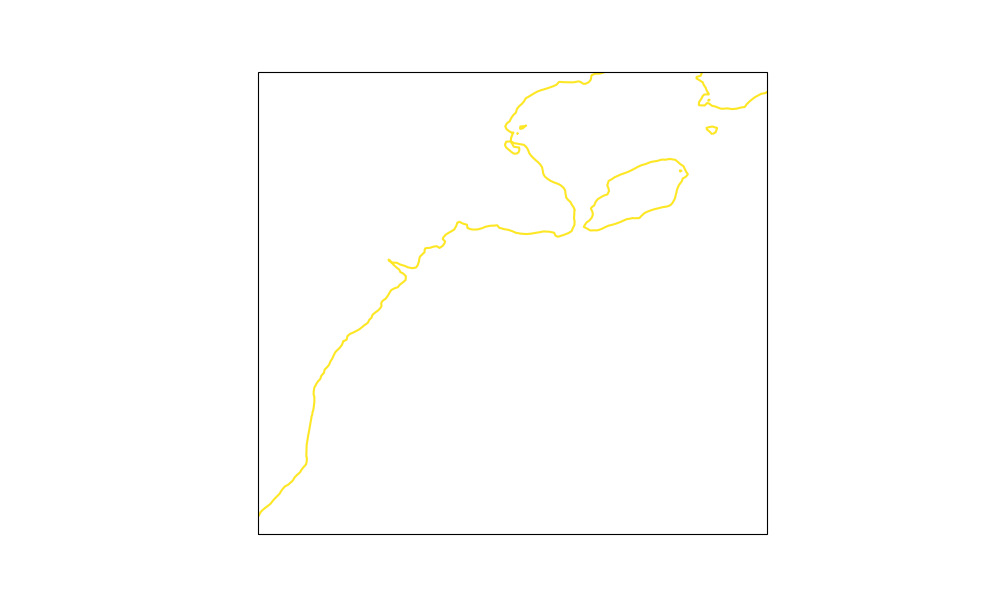

CPU times: user 6.63 s, sys: 3.82 s, total: 10.5 s
Wall time: 4.43 s


In [2]:
%%time
# pre-processing

# accessing dataset
link = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/DopAnV3R3-ini2007_da/year_avg"
chunk = {"ocean_time":1100}
ds = xroms.open_netcdf(link, chunks=chunk)

# bathymetry 

bathymetry = ds.h

extent = [-76,-65, 34, 44]
sigma = 8
lon_left = -75
lon_right = -70.65
isobath_value = 65
track_coords = track(ds, bathymetry, extent, lon_left, lon_right, isobath_value, sigma)

# track slices

AB_lon_lat, AB_ij = track_coords.AB_track(-0.74,50);
CD_lon_lat, CD_ij = track_coords.CD_track( 0.32,50);
BC_lon_lat, BC_ij = track_coords.BC_track();

#binding all slices of the track

final_ij_isobath = np.vstack((AB_ij[::-1], BC_ij, CD_ij))

final_lon_lat = np.vstack((AB_lon_lat[::-1], BC_lon_lat, CD_lon_lat))

lon_lat, ij_isobath = xr.DataArray(final_lon_lat), xr.DataArray(final_ij_isobath)
lon_lat, ij_isobath = lon_lat.rename({'dim_0':'along_track','dim_1':'lon_lat'}), ij_isobath.rename({'dim_0':'along_track', 'dim_1':'i_j'}) 

plt.close('all')

In [3]:
# loading the track interpolated dataset

daily_data = xr.open_dataset('./daily_data.nc', chunks={'ocean_time':1100})

temp = daily_data.temp
vel = -daily_data.normal_vel

# Analysis begings from here

In [17]:
# finding annual temperature and velocity 

annual_T = temp.resample(ocean_time='Y').mean(dim='ocean_time')
annual_V = vel.resample(ocean_time='Y').mean(dim='ocean_time')


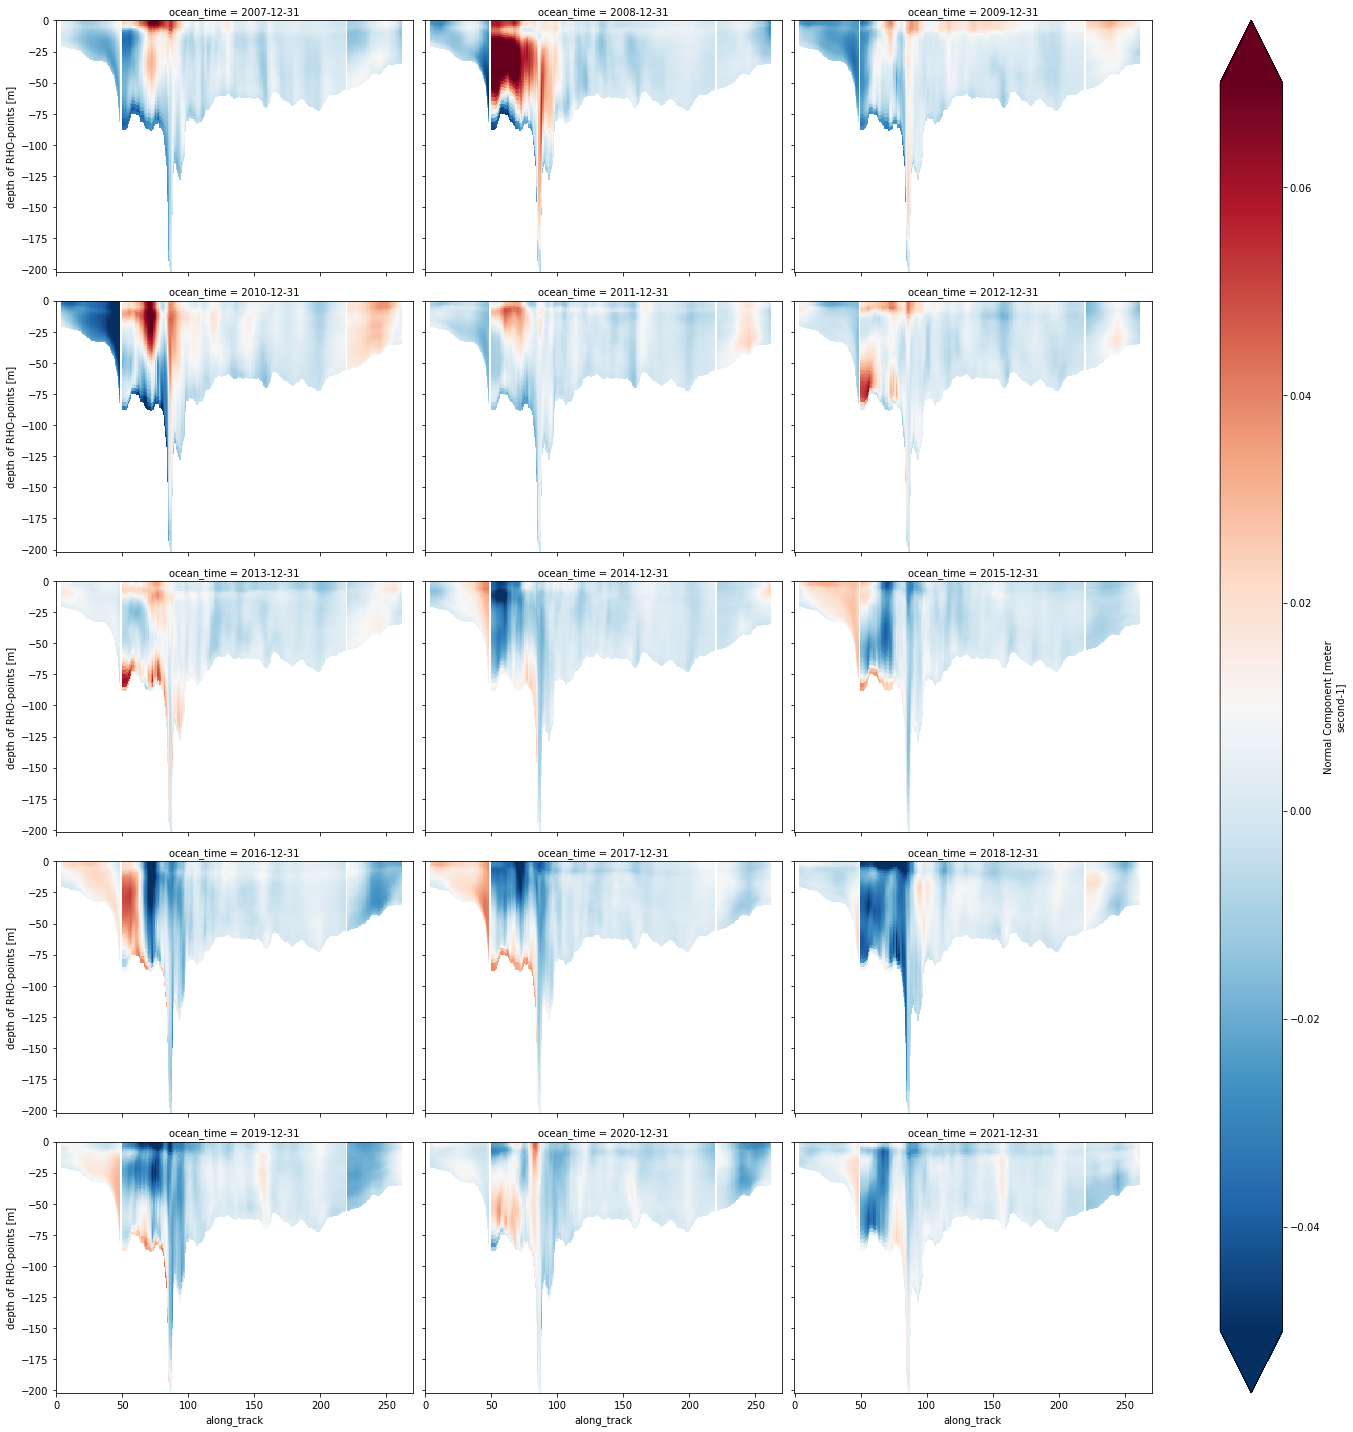

In [72]:
# plotting annual velocity over the track
annual_V = -annual_V

(annual_V  -  annual_V.mean(dim='ocean_time')).cf.plot(x='along_track', y='z_rho0', col='ocean_time', col_wrap=3, figsize=(20,20), vmin=-0.05, vmax=0.07, cmap='RdBu_r')

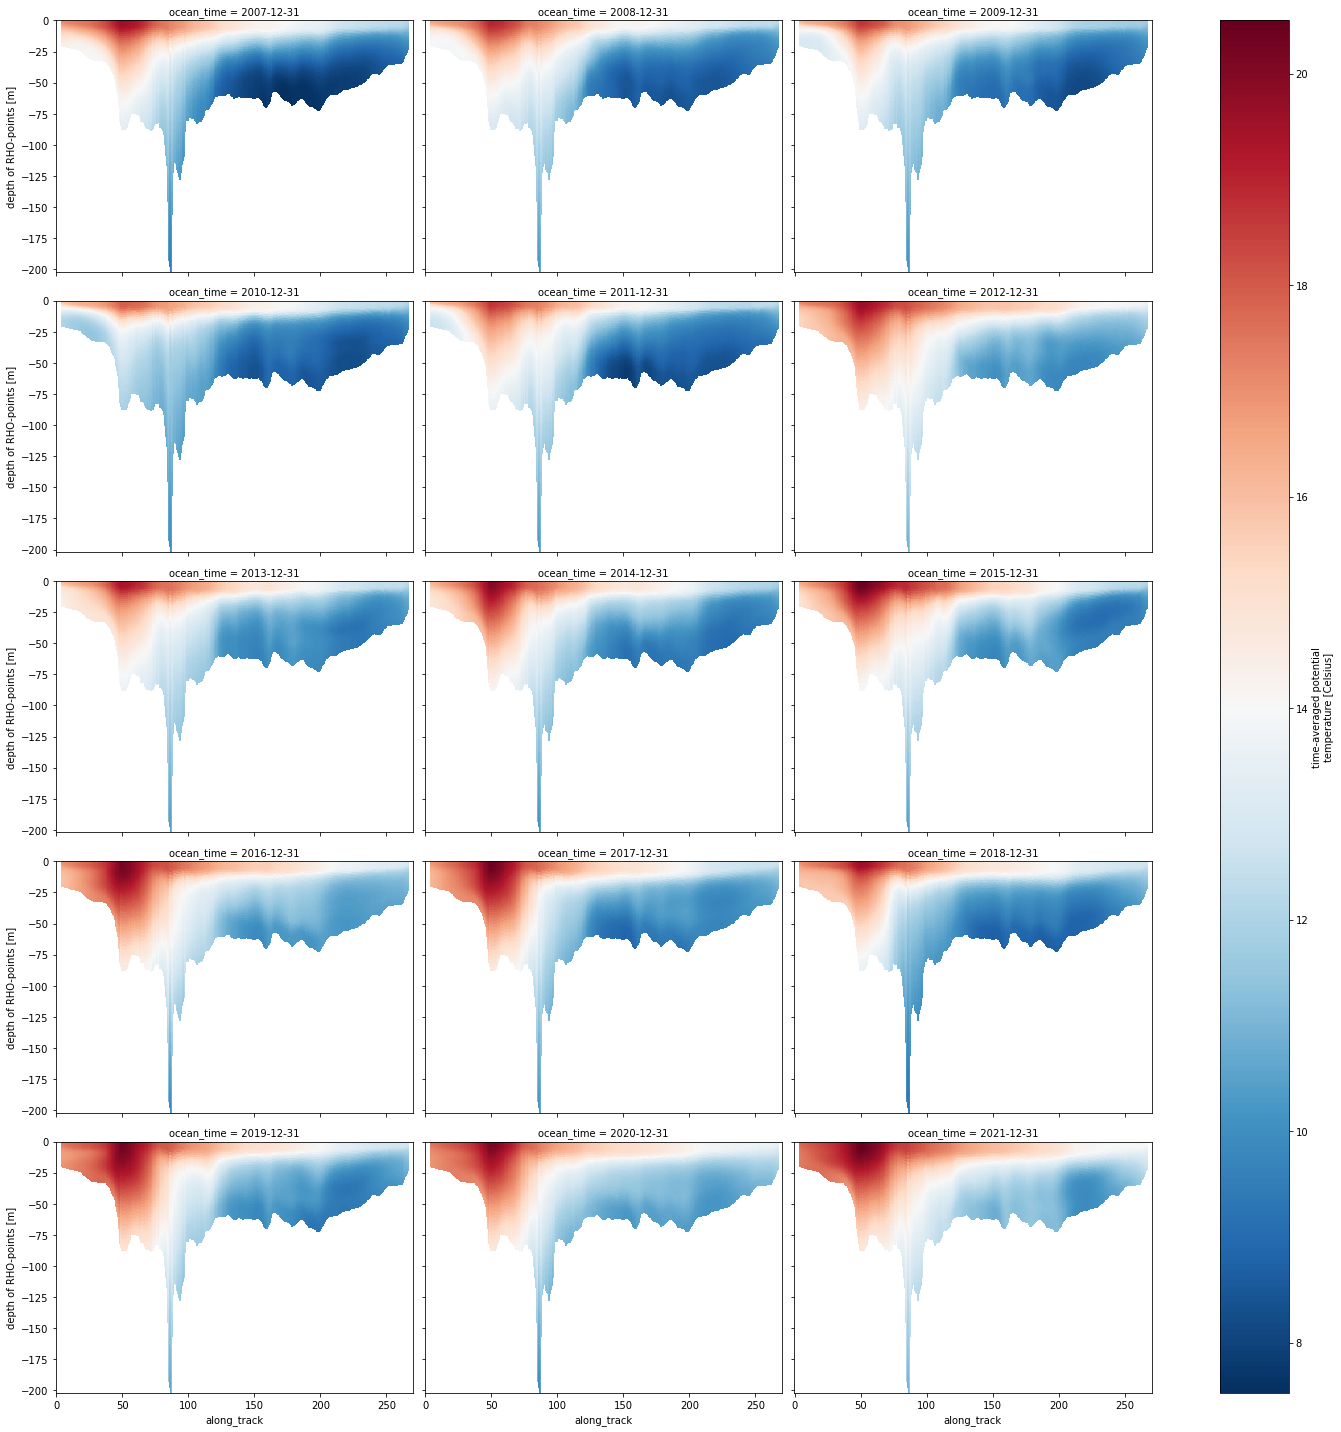

In [84]:
# plotting annual velocity over the track
(annual_T).cf.plot(x='along_track', y='z_rho0', col='ocean_time', col_wrap=3, figsize=(20,20), cmap='RdBu_r')

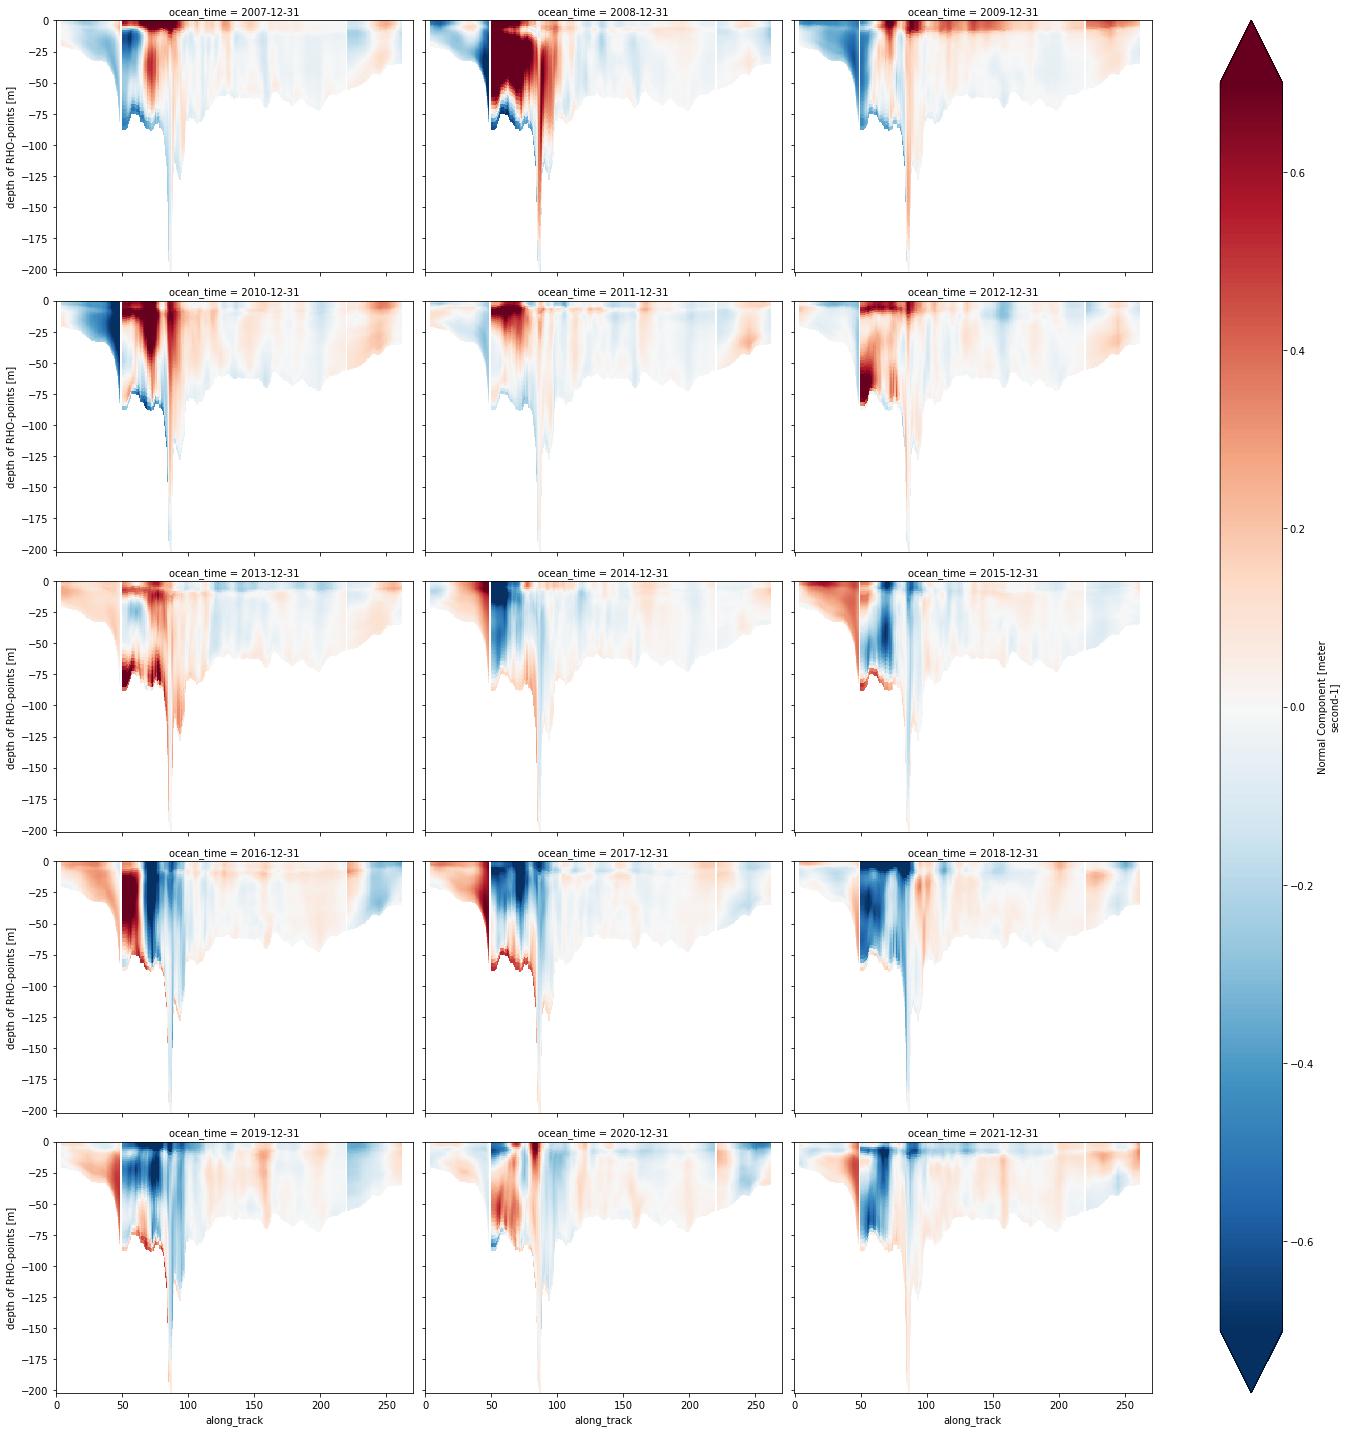

In [79]:
# plotting annual velocity*Temp variability over the track
vt = (-vel)*temp
vt_annual = vt.resample(ocean_time='Y').mean(dim='ocean_time')
(vt_annual - (vt_annual).mean(dim='ocean_time')).cf.plot(x='along_track', y='z_rho0', col='ocean_time', col_wrap=3, figsize=(20,20), vmin=-0.7, vmax=0.7, cmap='RdBu_r')

# debuging the grid

In [99]:
xi_rho, eta_rho = np.sort(final_ij_isobath[:,0]), np.sort(final_ij_isobath[:,1])

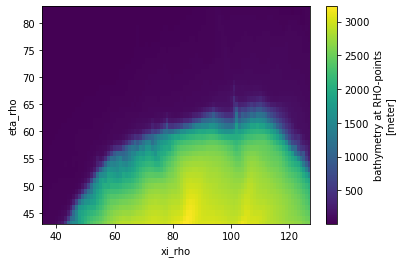

In [100]:
ds.h.sel(xi_rho=xi_rho, eta_rho=eta_rho, method='nearest').plot()

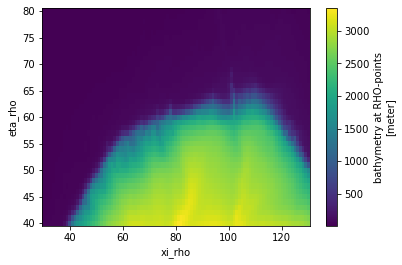

In [105]:
ds.h.sel(xi_rho=slice(30,130), eta_rho=slice(40,80)).plot()

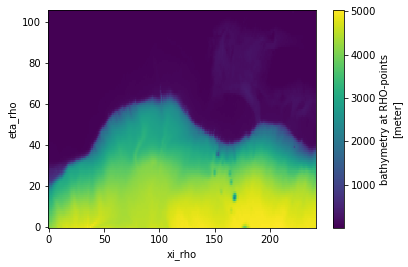

In [106]:
ds.h.plot(label=65)

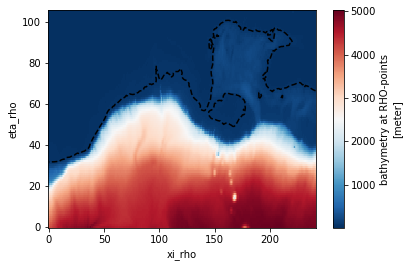

In [115]:
# Plot your bathymetry data
ds.h.plot(cmap='RdBu_r')

# Overlay a contour line at 65 m depth
plt.contour(ds.h.xi_rho, ds.h.eta_rho, ds.h, levels=[65], colors='k', linestyles='--')

plt.show()

(40.0, 60.0)

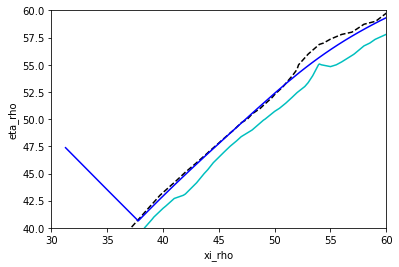

In [80]:
ds.h.plot.contour(levels=[65], colors='k', linestyles='--')
ds.h.plot.contour(levels=[200], colors='c')
plt.plot(final_ij_isobath[:,0],final_ij_isobath[:,1], 'b')
plt.xlim(30,60)
plt.ylim(40,60)

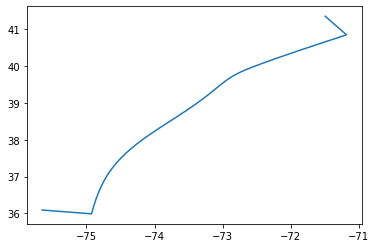

In [117]:
plt.plot(final_lon_lat[:,0],final_lon_lat[:,1])

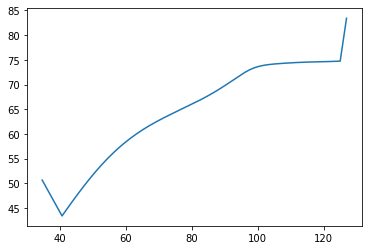

In [118]:
plt.plot(final_ij_isobath[:,0],final_ij_isobath[:,1])

In [153]:
from scipy.interpolate import griddata


#creating 2d mesh grid

xi_rho_2d, eta_rho_2d = np.meshgrid(np.arange(len(ds.h.xi_rho)),np.arange(len(ds.h.eta_rho)))
xi_rho_flat = xi_rho_2d.flatten()
eta_rho_flat = eta_rho_2d.flatten()
base_grid = np.column_stack((xi_rho_flat, eta_rho_flat))

# interpolation of bathymetry on the track

track_bathy = griddata(base_grid, ds.h.values.flatten(), final_ij_isobath, method='linear')

NameError: name 'ax' is not defined

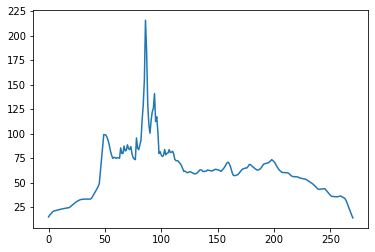

In [158]:
plt, ax = plt.
plt.plot(track_bathy)
ax.invert_yaxis()

In [146]:
len(ds.h.eta_rho)*len(ds.h.xi_rho)

25652

In [151]:
(ds.h.values.flatten()).shape

(25652,)

# check volume conservstion

In [7]:
# run this if the dataset is annual average

# calculating dz and ds

track_instance = track_coords 
interpol = interpolation(ds, lon_lat, ij_isobath[:,0], ij_isobath[:,1], track_instance);

dz = interpol.dz() 

dS = xr.DataArray(interpol.delta_s(lon_lat), dims=['along_track'])

dz = dz.isel(ocean_time=0)

dA = dS*dz
# dz = dz.mean(dim='ocean_time')
# plt.contourf(dz); plt.colorbar()
# dz.isel(s_rho=1).values
# vel.values[0,0,:]

The velocity divergence, $\nabla \cdot \mathbf{v}$, where $\mathbf{v}$ is the velocity vector, is given by:

$$
\nabla \cdot \mathbf{v} = \frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y} + \frac{\partial v_z}{\partial z}
$$

Here, $v_x$, $v_y$, and $v_z$ are the components of the velocity in the $x$, $y$, and $z$ directions, respectively.

now velocity correction can be written as $v_{corr}$ = $\frac{\int_{S} v(n) \,dS}{\int_{S} \,dS} $ 

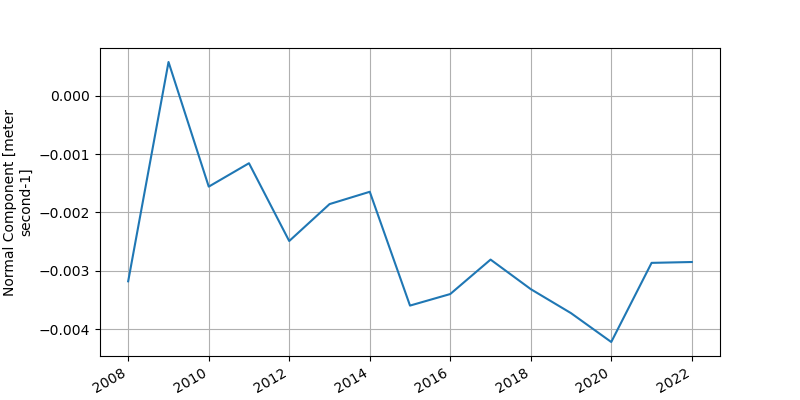

In [18]:
# calculatig normal velocity mean 
Total_area = dA.sum()
V_mean = ((vel.resample(ocean_time='Y').mean())*dA).sum(dim=['s_rho','along_track'])/Total_area
V_mean.plot(figsize=(8,4))
plt.grid()

In [19]:
v_corr = vel.resample(ocean_time='Y').mean(dim='ocean_time')
v_corr = ((v_corr*dA).sum(dim=['along_track','s_rho']))/Total_area

fig,ax = plt.subplots(figsize=(10,5))
V_mean.plot(label='mean velocity', ax=ax)
v_corr.plot(label=r'$v_{corr}$ = $\frac{\int_{S} v(n) \,dS}{\int_{S} \,dS} $ ', ax=ax)
plt.grid()
plt.legend()
# plt.savefig('plot1.pdf', dpi=400)

## Alright then let's calculate volume conservation time series for year 2007

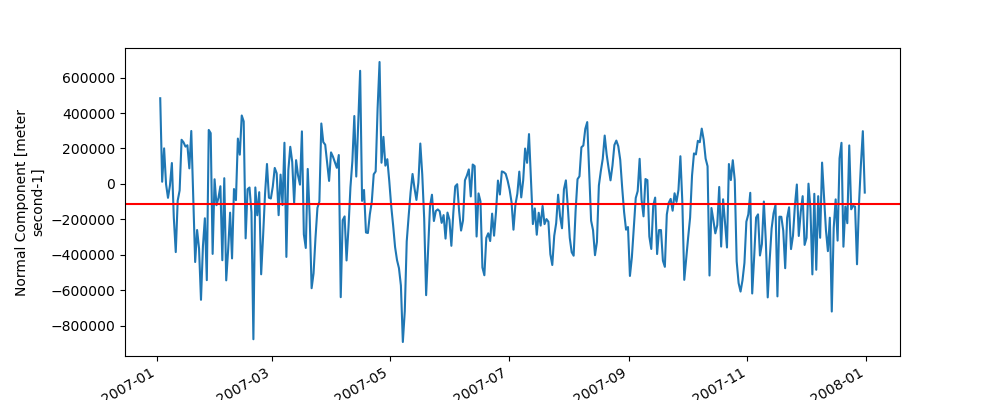

In [30]:
divergance = (vel.sel(ocean_time='2007')*dA).sum(dim=['along_track','s_rho'])
divergance.plot(figsize=(10,4))
y = divergance.mean(dim='ocean_time')
plt.axhline(y, color='r', linestyle='-')

 ### This time I am going to calculate v correction in different style`

/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/xarray/plot/utils.py:429: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=figsize)


-636.1564097471412


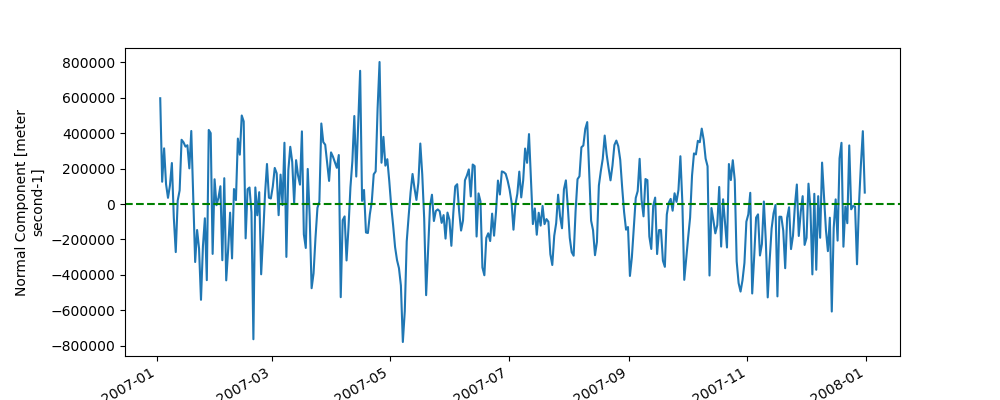

In [44]:
v_cor = (y/Total_area).values

divergance_new = ((vel.sel(ocean_time='2007') - v_cor)*dA).sum(dim=['along_track','s_rho'])
# divergance_new.plot(figsize=(10,4))
divergance_new.plot(figsize=(10,4))
y2 = divergance_new.mean(dim='ocean_time')
plt.axhline(y2, color='g', linestyle='--')
print(y2.values)

In [62]:
# closing all figures because its consuming memory

plt.close('all')


 
 #  
 
 #
 
 
 Alright so we are down to -636 $\text{m}^3/\text{s}$. The question is why not exactly 0? 
 
 Let's calculate with more accurate dz, I mean instead taking the mean dz lets take daily values
 
 .
 .

In [66]:
track_instance_daily = track_coords 

interpol_daily = interpolation(ds, lon_lat, ij_isobath[:,0], ij_isobath[:,1], track_instance_daily);

dz = interpol_daily.dz() 

In [75]:
dz_2007 = dz.sel(ocean_time='2007').compute()

In [80]:
%%time
dA = dz_2007*dS
Total_area =  dA.sum(dim=['along_track','s_rho'])
# v_corr = ((vel.sel(ocean_time='2007')*dA).sum(dim=['along_track','s_rho']))/Total_area

CPU times: user 28.9 ms, sys: 22.7 ms, total: 51.6 ms
Wall time: 43.5 ms


Text(0.5, 0, 'Time')

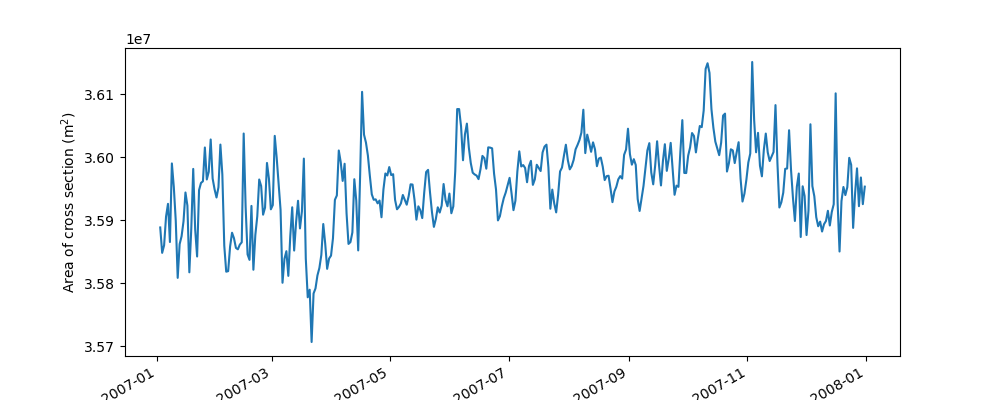

In [90]:
Total_area.plot(figsize=(10,4))
plt.ylabel(r'Area of cross section (m$^2$)')
plt.xlabel('Time')

In [91]:
plt.close('all')

In [92]:
%%time
v_corr = ((vel.sel(ocean_time='2007')*dA).sum(dim=['along_track','s_rho']))/Total_area

CPU times: user 115 ms, sys: 16.2 ms, total: 131 ms
Wall time: 128 ms


Text(0, 0.5, 'velocity correction $m/s$')

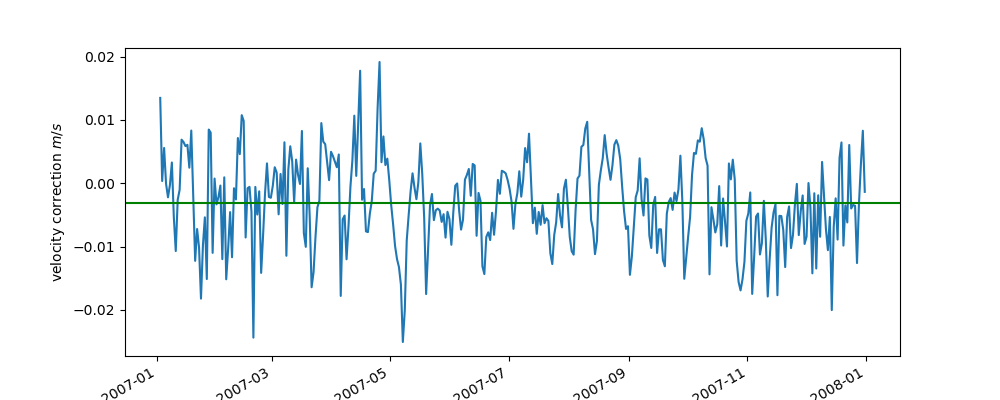

In [94]:
v_corr.plot(figsize=(10,4))
y3 = v_corr.mean(dim='ocean_time')
plt.axhline(y3, color='g', linestyle='-')
plt.ylabel(r'velocity correction $m/s$')

divergence in 2007 is: -638.410432119423


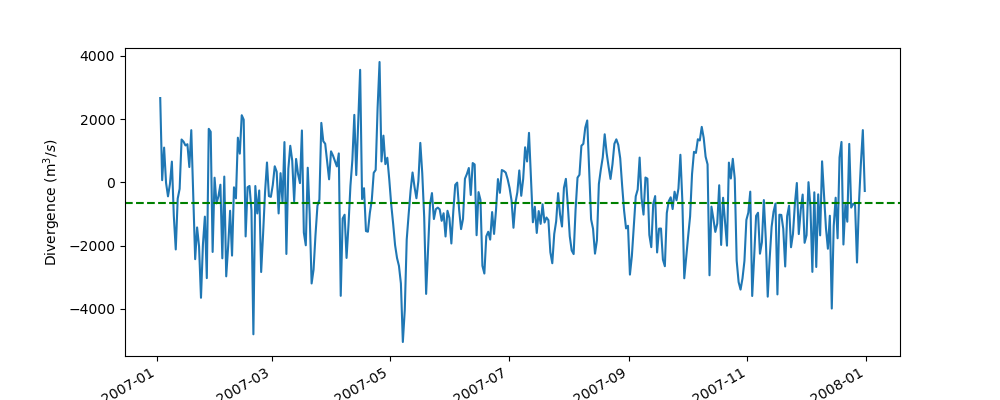

In [122]:
divergance_new = ((vel.sel(ocean_time='2007') - v_corr)*dA).sum(dim=['along_track','s_rho'])

divergance_new.plot(figsize=(10,4))

y4 = divergance_new.mean(dim='ocean_time')
plt.axhline(y4, color='g', linestyle='--')
plt.ylabel(r'Divergence (m$^3/s$)')
print("divergence in 2007 is:", y4.values)

In [123]:
divergance_new.std().values

array(1374.2495134)

.
.
Couldn't see any difference between the diverance over the year.

Let's try to calculate the machine error 

In [117]:
dA = dz_2007*dS
Total_area =  dA.sum(dim=['along_track','s_rho'])

machine_error = y4/Total_area.mean()

In [119]:
machine_error.values

array(-1.77559194e-05)

Now lets again make the velocity as:  $V - V_{corr} - machine_{error}$

In [121]:
V_new = vel.sel(ocean_time='2007') - v_corr - machine_error

divergence_new2 = ((V_new*dA).sum(dim=['along_track','s_rho'])).mean(dim='ocean_time')
divergence_new2.values

array(-3.55027424)

.
.
Let's create a random 2d dataset and do this (a + b)xc = ac + bc

In [144]:
ncol = 257
nrow = 40
a,c = np.random.rand(nrow,ncol), np.random.rand(nrow,ncol)
a = np.array(a, dtype=np.float64)
c = np.array(c, dtype=np.float32)
b = -0.00134556
# c = np.array(c, dtype=np.int32)

In [145]:
np.sum((a - b)*c), np.sum(a*c) - np.sum(b*c)

(2558.883183486665, 2558.8831832329706)

.
.

Well this didn't quite work

In [155]:
dz_2007.isel(ocean_time=260, along_track=9).values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])

In [156]:
vel.isel(ocean_time=260, along_track=9).values

array([-0.07745016, -0.08924092, -0.09550546, -0.09992747, -0.10343672,
       -0.1065776 , -0.10969754, -0.11267189, -0.11569298, -0.11888862,
       -0.12212425, -0.12547991, -0.12850478, -0.13039276, -0.1312061 ,
       -0.13144742, -0.13145029, -0.13150045, -0.13157598, -0.13171555,
       -0.13190244, -0.13214034, -0.13243341, -0.13279381, -0.13323889,
       -0.13375227, -0.13435642, -0.13506311, -0.13588077, -0.13680616,
       -0.13781967, -0.13893755, -0.1401606 , -0.1414729 , -0.14289424,
       -0.14449632, -0.14635225, -0.14854919, -0.15119777, -0.15443673])

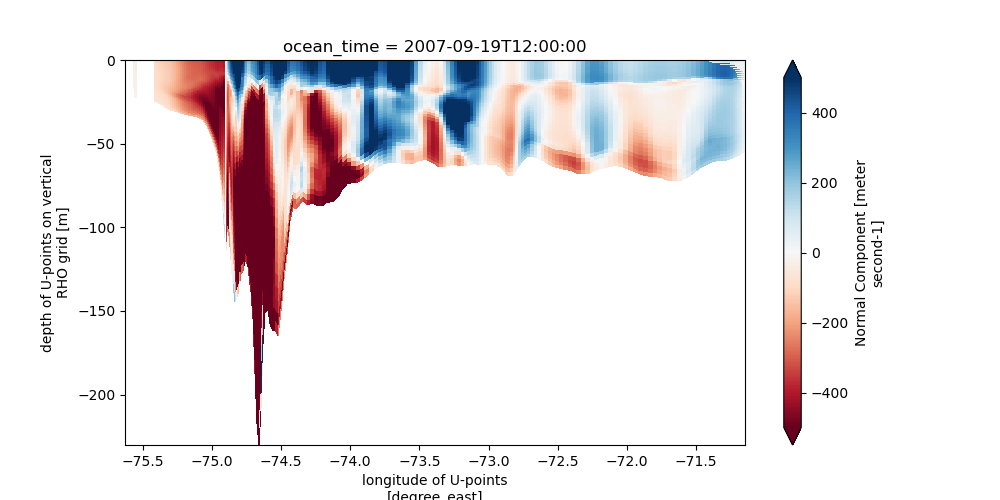

In [171]:
(vel.isel(ocean_time='2007')*dz_2007.isel(ocean_time=260)*dS).cf.plot(figsize=(10,5), vmin=-500, vmax=500, cmap='RdBu')



divergence of v_model is: -114551.93430270485


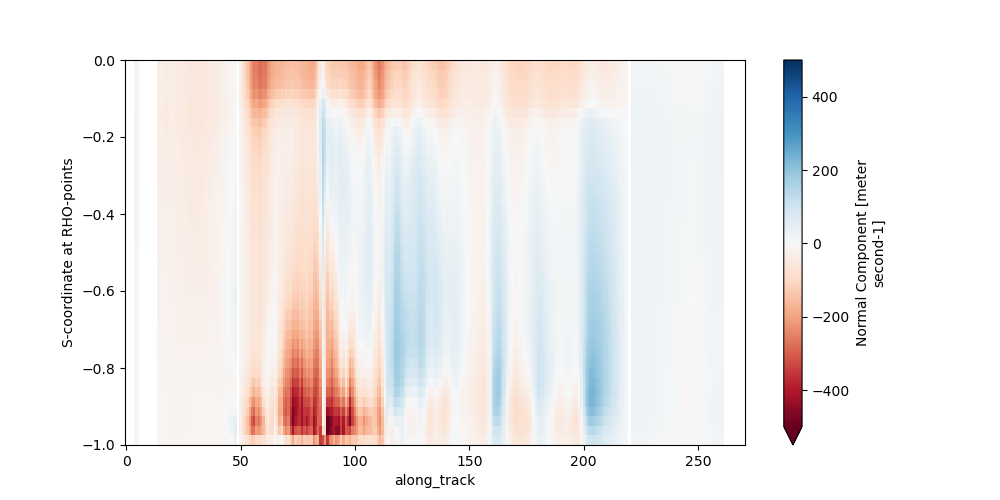

In [194]:
((vel.sel(ocean_time='2007')*dz_2007*dS).mean(dim='ocean_time')).plot( figsize=(10,5), vmin=-500, vmax=500, cmap='RdBu')

print('divergence of v_model is:', ((vel.sel(ocean_time='2007')*dz_2007*dS).mean(dim='ocean_time')).sum().values)


divergence of v_correction is: -114551.93430270485
last nine element sum is: -524.5347961450494
last nine element sum is: -583.3060227058986


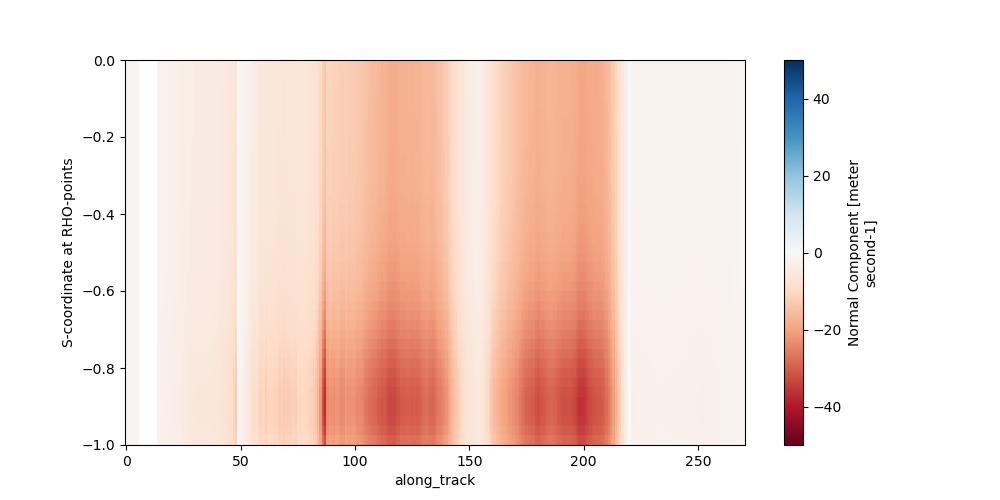

In [220]:
(v_corr*dz_2007*dS).mean(dim='ocean_time').plot(figsize=(10,5), vmin=-50, vmax=50, cmap='RdBu')

print('divergence of v_correction is:', ((v_corr*dz_2007*dS).mean(dim='ocean_time')).sum().values)

# Corrected print statement and slice usage
print('last nine element sum is:', ((v_corr * dz_2007 * dS).isel(along_track=slice(-9, None)).mean(dim='ocean_time')).sum().values)
print('last nine element sum is:', ((v_corr * dz_2007 * dS).isel(along_track=slice(-9, None)).mean(dim='ocean_time')).sum().values + ((v_corr * dz_2007 * dS).isel(along_track = slice(4,6)).mean(dim='ocean_time')).sum().values)


In [187]:
a = ((vel.sel(ocean_time='2007')*dz_2007*dS).mean(dim='ocean_time'))
b = (v_corr*dz_2007*dS).mean(dim='ocean_time')


In [188]:
plt.close('all')

divergence of v - v_correction is: -638.4104321194318


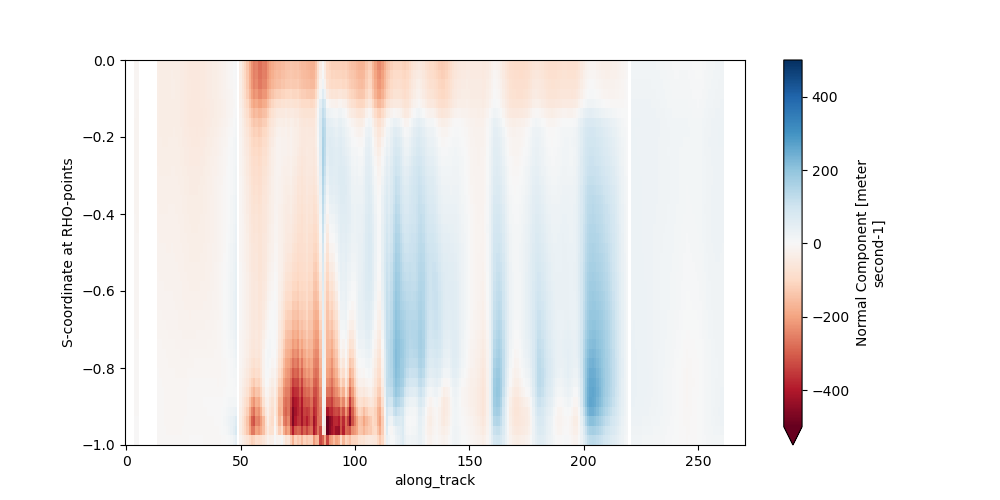

In [193]:
(a-b).plot(figsize=(10,5), vmin=-500, vmax=500, cmap='RdBu')

print('divergence of v - v_correction is:', (a-b).sum().values)

In [218]:
dz_2007.isel(ocean_time=0,s_rho=-1, along_track = slice(4,6)).values

array([0.12885229, 0.13137857])

In [206]:
vel.isel(ocean_time=0,s_rho=-1).values

array([            nan,             nan,             nan,             nan,
       -1.85699376e-01, -1.86806350e-01, -1.85996275e-01, -1.83737242e-01,
       -1.80087731e-01, -1.74907444e-01, -1.68271583e-01, -1.60262492e-01,
       -1.51133915e-01, -1.50482359e-01, -1.49853805e-01, -1.49289980e-01,
       -1.48725432e-01, -1.48165143e-01, -1.47700317e-01, -1.45326064e-01,
       -1.43020999e-01, -1.41181995e-01, -1.39422346e-01, -1.37704118e-01,
       -1.35978742e-01, -1.34289585e-01, -1.32166905e-01, -1.29506046e-01,
       -1.26243204e-01, -1.23209098e-01, -1.20530340e-01, -1.17967461e-01,
       -1.16560883e-01, -1.16603592e-01, -1.16834764e-01, -1.17189176e-01,
       -1.17659422e-01, -1.19423087e-01, -1.22445700e-01, -1.28325718e-01,
       -1.35520543e-01, -1.42963585e-01, -1.50573191e-01, -1.58383398e-01,
       -1.66351176e-01, -1.75518326e-01, -1.83040387e-01, -1.88624891e-01,
       -1.92472583e-01,             nan, -6.25250783e-02, -6.14769782e-02,
       -5.91486153e-02, -

### So the problem was that velocity was interpolated from u,v points (face center) and tracers were interpolated from rho points (center) and because of that there were inconsistency at the end of the track

In [107]:
%%time 

u_strip = ds.u.isel()

i = np.arange(len(u_strip.xi_u)-1)
U_rho_left, U_rho_center, U_rho_right = 2*u_strip[:,:,:,0].values - u_strip[:,:,:,1].values, 0.5*(u_strip[:,:,:,i+1].values + u_strip[:,:,:,i].values), 2*u_strip[:,:,:,-1].values - u_strip[:,:,:,-2].values

u_rho_left = np.expand_dims(U_rho_left, axis=3)
u_rho_right = np.expand_dims(U_rho_right, axis=3)

u_rho = np.concatenate((u_rho_left, U_rho_center, u_rho_right), axis=3) 




CPU times: user 576 ms, sys: 222 ms, total: 798 ms
Wall time: 791 ms


In [113]:
u_rho = xr.DataArray(u_rho, 
                     {'ocean_time':ds.ocean_time,
                      's_rho': ds.s_rho,
                      'eta_rho': ds.eta_rho,
                         'xi_rho': ds.xi_rho}, attrs=ds.u.attrs)

In [114]:
u_rho

<xarray.DataArray (ocean_time: 15, s_rho: 40, eta_rho: 106, xi_rho: 242)>
array([[[[-5.23816573e-02, -2.08800418e-02,  3.48520734e-03, ...,
          -4.76776374e-02, -4.74084098e-02, -4.67155118e-02],
         [-8.16829070e-02, -3.77923625e-02, -8.71702380e-03, ...,
          -4.45234211e-02, -4.59473767e-02, -4.82841932e-02],
         [-6.58088848e-02, -4.96191733e-02, -3.68867362e-02, ...,
          -4.66421587e-02, -4.62161732e-02, -4.70833457e-02],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[-5.14549132e-02, -2.07101532e-02,  3.69600112e-03, ...,
          -4.59599589e-02, -4.54580910e-02, -4.47201620e-02],
         [-8.05244889e-02, -3.69814553e-02, -8.94070737e-03, ...,
          -4.20657477e-02, -4.34785771e-02, -4.72357431e-02],
         [-6.24557518e-02, -4.75149815e-02, -3.51916704e-02, ...,
          -4.64454142e-02, -4.63895870e-02, -4.77345507e-02],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[-1.68371148e-01, -1.43096009e-01, -1.23151410e-01, ...,
           2.15213159e-01,  2.11679775e-01,  2.12778530e-01],
         [-1.72202915e-01, -1.66510114e-01, -1.55710458e-01, ...,
           1.85026629e-01,  1.98217186e-01,  2.41854492e-01],
         [-1.30425157e-01, -1.37316872e-01, -1.33911849e-01, ...,
           1.41588275e-01,  1.56167408e-01,  1.94349983e-01],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2007-07-01T18:00:00 ... 2021-07-0...
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 7 ... 99 100 101 102 103 104 105
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 235 236 237 238 239 240 241
Attributes:
    long_name:      time-averaged u-momentum component
    units:          meter second-1
    time:           ocean_time
    field:          u-velocity, scalar, series
    cell_methods:   ocean_time: mean
    standard_name:  sea_water_x_velocity
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...

In [69]:
i = np.arange(len(u_strip.xi_u)-1)
print(len(i))
print(len(0.5*(u_strip[i].values + u_strip[i+1].values)))
print(len(0.5*(u_strip[i] + u_strip[i+1])))

240
240
239


In [139]:
# u_rho.isel(s_rho=-1).cf.plot(col='ocean_time', col_wrap=3, figsize=(20,20), vmin=-0.5, vmax=1, cmap='RdBu_r')
plt.close('all')

In [152]:
%%time 

v_strip = ds.v

i = np.arange(len(v_strip.eta_v)-1)
V_rho_left, V_rho_center, V_rho_right = 2*v_strip[:,:,0,:].values - v_strip[:,:,1,:].values, 0.5*(v_strip[:,:,i+1,:].values + v_strip[:,:,i,:].values), 2*v_strip[:,:,-1,:].values - v_strip[:,:,-2,:].values

v_rho_left = np.expand_dims(V_rho_left, axis=2)
v_rho_right = np.expand_dims(V_rho_right, axis=2)

v_rho = np.concatenate((v_rho_left, V_rho_center, v_rho_right), axis=2) 


CPU times: user 1.13 s, sys: 565 ms, total: 1.7 s
Wall time: 2.56 s


In [153]:
v_rho = xr.DataArray(v_rho, 
                     dims=['ocean_time','s_rho', 'eta_rho', 'xi_rho'],
                     
                     coords = {'ocean_time':ds.ocean_time,
                      's_rho': ds.s_rho,
                      'eta_rho': ds.eta_rho,
                         'xi_rho': ds.xi_rho,
                     'lon_rho':ds.lon_rho,'lat_rho':ds.lat_rho,'z_rho':ds.z_rho,'z_rhoO':ds.z_rho0},
                     attrs=ds.v.attrs)

In [161]:
# v_rho.isel(s_rho=-1).plot(col='ocean_time', col_wrap=3, figsize=(20,20), cmap='RdBu_r', vmin=-0.5,vmax=0.5)
plt.close('all')

In [188]:
def rho_velocity(component):
    if component == 'u':
        u_strip = ds.u.fillna(0)

        i = np.arange(len(ds.xi_u)-1)
        U_rho_left, U_rho_center, U_rho_right = 2*u_strip[:,:,:,0].values - u_strip[:,:,:,1].values, 0.5*(u_strip[:,:,:,i+1].values + u_strip[:,:,:,i].values), 2*u_strip[:,:,:,-1].values - u_strip[:,:,:,-2].values

        u_rho_left = np.expand_dims(U_rho_left, axis=3)
        u_rho_right = np.expand_dims(U_rho_right, axis=3)

        u_rho = np.concatenate((u_rho_left, U_rho_center, u_rho_right), axis=3) 
        
        rho_velocity = xr.DataArray(u_rho,
                            dims=['ocean_time', 's_rho', 'eta_rho', 'xi_rho'],
                            coords = {'ocean_time': ds.ocean_time,
                                     's_rho': ds.s_rho,
                                     'eta_rho': ds.eta_rho,
                                     'xi_rho': ds.xi_rho,
                                     'lon_rho': ds.lon_rho,
                                     'lat_rho': ds.lat_rho,
                                     'z_rho': ds.z_rho,
                                     'z_rhoO': ds.z_rho0},
                            attrs = ds.u.attrs)
        
    elif component == 'v':
        
        v_strip = ds.v.fillna(0)

        i = np.arange(len(ds.eta_v)-1)
        V_rho_left, V_rho_center, V_rho_right = 2*v_strip[:,:,0,:].values - v_strip[:,:,1,:].values, 0.5*(v_strip[:,:,i+1,:].values + v_strip[:,:,i,:].values), 2*v_strip[:,:,-1,:].values - v_strip[:,:,-2,:].values

        v_rho_left = np.expand_dims(V_rho_left, axis=2)
        v_rho_right = np.expand_dims(V_rho_right, axis=2)

        v_rho = np.concatenate((v_rho_left, V_rho_center, v_rho_right), axis=2) 
        
        rho_velocity = xr.DataArray(v_rho, 
                     dims=['ocean_time','s_rho', 'eta_rho', 'xi_rho'],
                     
                     coords = {'ocean_time':ds.ocean_time,
                      's_rho': ds.s_rho,
                      'eta_rho': ds.eta_rho,
                         'xi_rho': ds.xi_rho,
                     'lon_rho':ds.lon_rho,'lat_rho':ds.lat_rho,'z_rho':ds.z_rho,'z_rhoO':ds.z_rho0},
                     attrs=ds.v.attrs)
        
    else :
        print("ERROR: function rho_velocity() only expects 'u' and 'v' as an argument")
        
    mask = ds.mask_rho
    return rho_velocity*(mask.where(mask != 0))
#     return rho_velocity
        

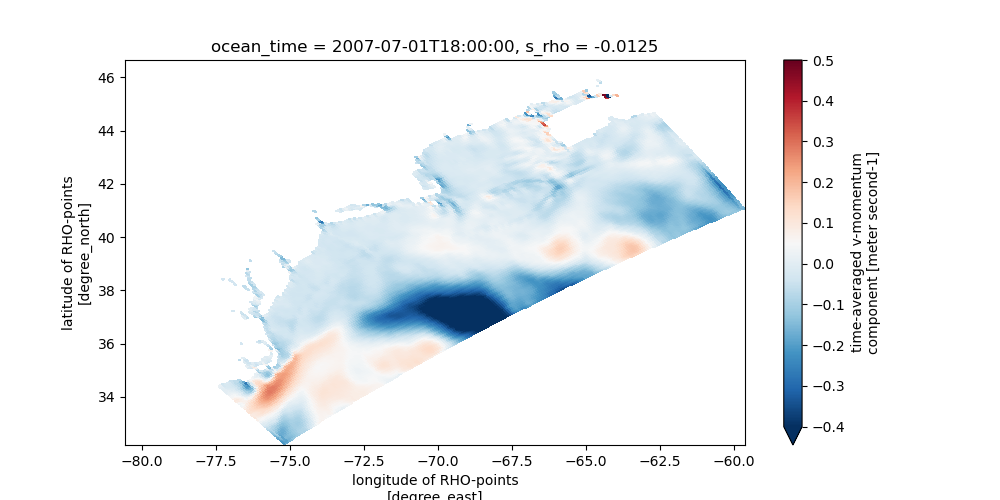

In [187]:
rho_velocity('v').isel(s_rho=-1,ocean_time=0).plot(x='lon_rho', y='lat_rho', figsize=(10,5), cmap='RdBu_r', vmin=-0.4, vmax=0.5)

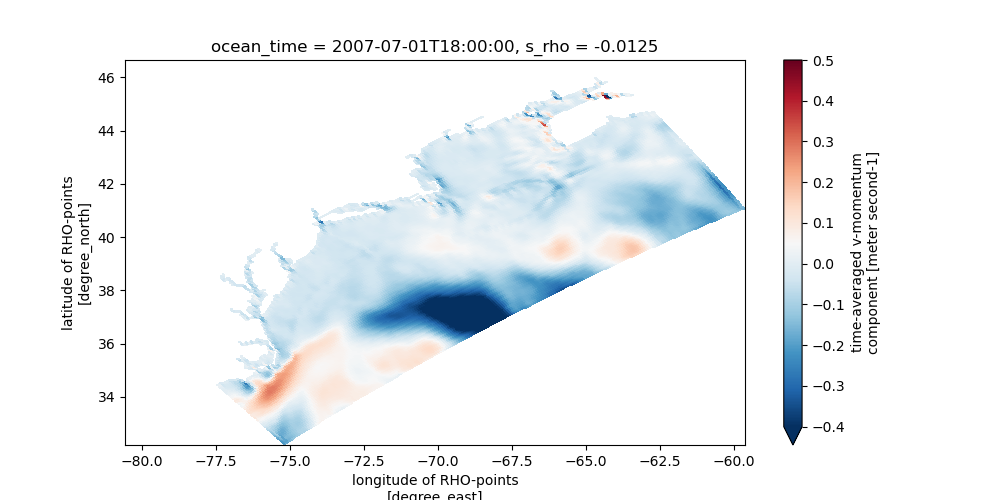

In [189]:
v = rho_velocity('v')
v.isel(s_rho=-1,ocean_time=0).plot(x='lon_rho', y='lat_rho', figsize=(10,5), cmap='RdBu_r', vmin=-0.4, vmax=0.5)

In [3]:
# Now I've got u and v at the rho points, I need to interpolate this on the track so that my track would be on rho
# points. 

# get temperature, velocity and z value on the tracks

track_instance = track_coords 
interpol = interpolation(ds, lon_lat, ij_isobath[:,0], ij_isobath[:,1], track_instance);

# interpolating temperature and velocity
temp = interpol.temperature();
nvel, pvel = interpol.velocity();
dz = interpol.dz() 
dS = xr.DataArray(interpol.delta_s(lon_lat), dims=['along_track'])


<class 'xarray.core.dataarray.DataArray'>
temp_trk time dimension:  ['2007-07-01T18:00:00.000000000' '2008-07-01T14:00:00.000000000'
 '2009-07-01T17:00:00.000000000' '2010-07-01T17:00:00.000000000'
 '2011-07-01T17:00:00.000000000' '2012-07-01T14:00:00.000000000'
 '2013-07-01T17:00:00.000000000' '2014-07-01T17:00:00.000000000'
 '2015-07-01T17:00:00.000000000' '2016-07-01T14:00:00.000000000'
 '2017-07-01T17:00:00.000000000' '2018-07-01T17:00:00.000000000'
 '2019-07-01T17:00:00.000000000' '2020-07-01T14:00:00.000000000'
 '2021-07-01T14:00:00.000000000']


/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)


In [19]:
# nvel.cf.plot(col='ocean_time', col_wrap = 3, figsize=(20,20), cmap='RdBu_r', vmin=-0.05, vmax=0.05)
plt.close('all')
# nvel.isel(s_rho=-1, ocean_time=0).values
# dz.isel(s_rho=-1, ocean_time=0).values

In [22]:
dz = dz.mean(dim='ocean_time')

In [52]:
dA = dz*dS
Total_area = dA.sum(dim=['along_track', 's_rho'])

v_corr = ((nvel*dA).sum(dim=['along_track','s_rho']))/Total_area

v_modified = -(nvel - v_corr)

divergence = (v_modified*dA).sum(dim=['along_track','s_rho'])

In [53]:
divergence.values

array([-1.95711891e-10,  3.96624955e-11, -3.07522896e-11,  8.15703061e-11,
       -7.21911420e-11, -1.33638878e-10,  5.62749847e-11,  6.36646291e-12,
        1.15960574e-11, -2.48689958e-12,  6.96900315e-11, -5.68434189e-11,
       -1.79511517e-10,  1.16926913e-10, -1.44666501e-10])

# alright now it follows the volume conservation part

In [56]:

# creating mask
def mask_roi(AB_ij, CD_ij):
    '''
    input as AB_ij and CD_ij
    
    '''
    x1,y1 = AB_ij[0]
    x2,y2 = AB_ij[-1]

    m = (y2-y1)/(x2-x1)
    y = y2-m*x2

    x1,y1 = CD_ij[0]
    x2,y2 = CD_ij[-1]

    m = (y2-y1)/(x2-x1)
    x = (106 - y2)/m + x2

    vertices1 = (0, y)  
    vertices2 = (x,106)


    import matplotlib.path as mpath

    def create_mask(shape, polygon):
        y,x = np.mgrid[:shape[0], :shape[1]]
        points = np.column_stack((x.ravel(), y.ravel()))
        path = mpath.Path(polygon)
        mask = path.contains_points(points).reshape(shape)

        return mask

    shape = (106, 242)
    polygon = np.vstack((vertices1, final_ij_isobath, vertices2))
    # polygon = final_ij_isobath


    mask = create_mask(shape, polygon)
    new_mask = (ds.mask_rho*mask)
    new_mask.plot(figsize=(10,5))
    
    return new_mask
    


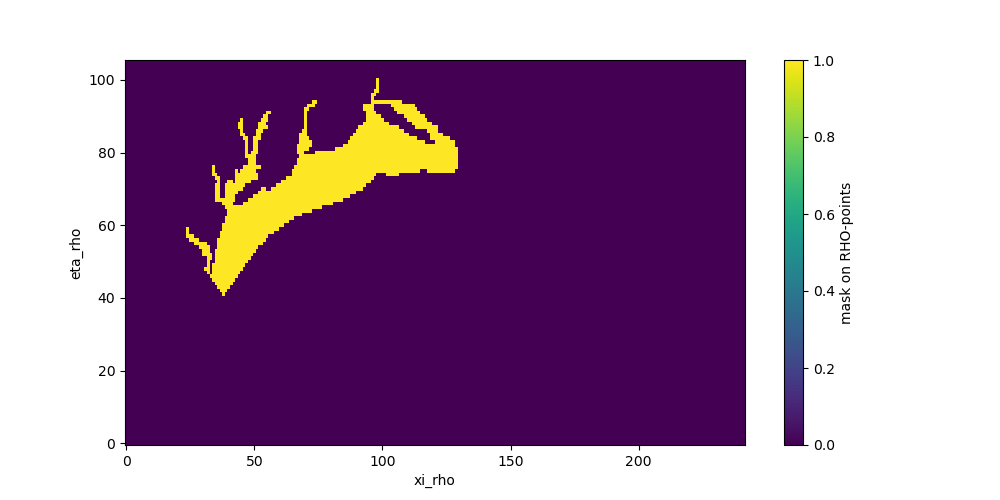

In [33]:
mask = mask_roi(AB_ij, CD_ij)

In [38]:
vtemp = (ds.temp*mask).sum(dim=['eta_rho','xi_rho','s_rho'])/(ds.dV*mask).sum(dim=['eta_rho','xi_rho','s_rho'])
temp_modified = temp - vtemp

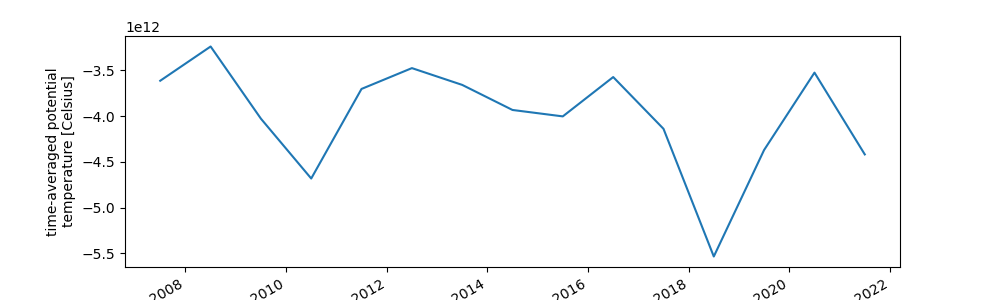

In [55]:
# calculating the annual heat transfer
rho, cp = 1025, 3985

heat_annual = (rho*cp*(temp_modified*v_modified)*dA).sum(dim=['along_track','s_rho'])
heat_annual.plot(figsize=(10,3))

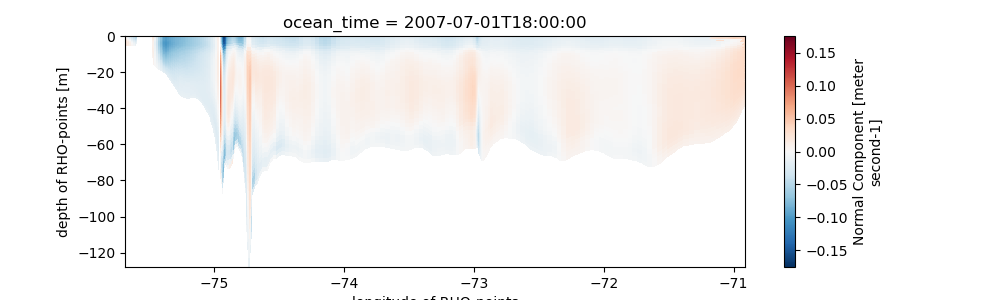

In [54]:
v_modified.isel(ocean_time=0).cf.plot(figsize=(10,3))

<xarray.DataArray 'temp' (ocean_time: 15, s_rho: 40, along_track: 271)>
dask.array<getitem, shape=(15, 40, 271), dtype=float64, chunksize=(15, 40, 271), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    lon_rho     (along_track) float64 dask.array<chunksize=(271,), meta=np.ndarray>
    lat_rho     (along_track) float64 dask.array<chunksize=(271,), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2007-07-01T18:00:00 ... 2021-07-0...
    z_rho       (ocean_time, s_rho, along_track) float64 dask.array<chunksize=(15, 40, 271), meta=np.ndarray>
    z_rho0      (s_rho, along_track) float64 dask.array<chunksize=(40, 271), meta=np.ndarray>
    xi_rho      (along_track) float64 31.26 31.39 31.53 ... 129.1 129.1 129.1
    eta_rho     (along_track) float64 47.38 47.24 47.1 ... 80.75 80.87 80.98
Dimensions without coordinates: along_track
Attributes:
    long_name:      time-averaged potential temperature
    units:          Celsius
    time:           ocean_time
    field:          temperature, scalar, series
    cell_methods:   ocean_time: mean
    standard_name:  sea_water_potential_temperature
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...


# Debug Annual heat transport component

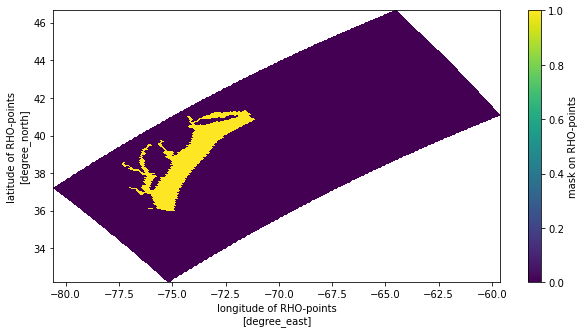

In [143]:
# creating mask

x1,y1 = AB_ij[0]
x2,y2 = AB_ij[-1]

m1 = (y2-y1)/(x2-x1)
y = y2-m1*x2

x1,y1 = CD_ij[0]
x2,y2 = CD_ij[-1]

m2 = (y2-y1)/(x2-x1)
x = (106 - y2)/m2 + x2

vertices1 = (0, y)  
vertices2 = (x,106)


import matplotlib.path as mpath

def create_mask(shape, polygon):
    y,x = np.mgrid[:shape[0], :shape[1]]
    points = np.column_stack((x.ravel(), y.ravel()))
    path = mpath.Path(polygon)
    mask = path.contains_points(points).reshape(shape)
    
    return mask

shape = (106, 242)
polygon = np.vstack((vertices1, final_ij_isobath, vertices2))
# polygon = final_ij_isobath


mask = create_mask(shape, polygon)
new_mask = (ds.mask_rho*mask)
new_mask.plot(figsize=(10,5), x='lon_rho', y='lat_rho')

In [158]:
temp = ds.temp
dv = ds.dV
dA = dS*dz
rho, cp = 1025, 3985 # volumetric heat capacity


def Total_heat(temp,new_mask,vel, dz,dS):
    
    T_mean = ((temp*new_mask)*dv).sum(dim=['eta_rho','s_rho','xi_rho'])/ (dv*new_mask).sum(dim=['eta_rho','s_rho','xi_rho'])
    
    v_mean = (vel.resample(ocean_time='Y').mean(dim='ocean_time'))

    v_surface_integral = (v_mean*dA).sum()

    v_correction = v_surface_integral/dA.sum()
    
    v = []
    t = []

    for i in np.arange(len(v_correction.ocean_time)):
        
        v_mod = vel.sel(ocean_time = str(v_correction.ocean_time.dt.year[i])) - v_correction.isel(ocean_time = i)
        
        t_mod = temp.sel(ocean_time = str(v_correction.ocean_time.dt.year[i])) - T_mean.isel(ocean_time = i)
        
        v.append(v_mod)
        t.append(t_mod)
        
    V_mod = xr.concat(v, dim='ocean_time')
    T_mod = xr.concat(t, dim='ocean_time')
    
    
        
    
    return (rho*cp*((V_mod*T_mod).resample(ocean_time='Y').mean(dim='ocean_time'))*dA).sum(dim=['s_rho','along_track'])
    
    

In [159]:
heat = Total_heat(temp,new_mask,vel, dz,dS)

TypeError: len() of unsized object

In [153]:
v_correction

<xarray.DataArray (ocean_time: 15)>
dask.array<truediv, shape=(15,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2007-12-31 2008-12-31 ... 2021-12-31
Attributes:
    long_name:      Normal Component
    units:          meter second-1
    time:           ocean_time
    location:       edge1
    field:          u-velocity, scalar, series
    _ChunkSizes:    [  1  20  53 121]
    standard_name:  sea_water_x_velocity